# Detecting the Optimal NYC Neighborhood to Invest in Sports Retail

Importing relevant libraries

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler

json file downloaded and imported from https://geo.nyu.edu/catalog/nyu_2451_34572

In [3]:
with open('nyu-2451-34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [5]:
neighborhoods.head(n=10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


Finding the coordinates of NYC

In [6]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [7]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Foursquare developer credentials

In [8]:
CLIENT_ID = 'MAX0FUKBEU0H0RL2UJB2ZV0N32DUFLE0H3PFDBYSYUNM2W3Q' 
CLIENT_SECRET = 'WA05K42XQHWJHJI11EP0GLNTMNZWRMUCNCNVW2MSIQPT5UTK' 
VERSION = '20180605'

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        try:
        # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print("error")
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Id',  
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
LIMIT = 100
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

Keeping only venues which are retailed to sports. The different categories used for filtering where found from the official page of Foursqure venue categories, https://developer.foursquare.com/docs/build-with-foursquare/categories/

In [11]:
sport_venues_truth_values = newyork_venues['Venue Category'].isin(['Badminton Court' , 'Baseball Field','Basketball Court','Bowling Green','Curling Ice','Golf Course','Golf Driving Range','Boxing Gym','Climbing Gym','Cycle Studio','Gym Pool','Gym','Martial Arts Dojo','Track','Hockey Field','Rugby Pitch','Tennis Court','Volleyball Court','Squash Court','Soccer Field','Skating Rink','Skate Park','Weight Loss Center'])
newyork_sports_venues = newyork_venues[sport_venues_truth_values]
print(newyork_sports_venues.shape)
newyork_sports_venues.head(n=15)

(999, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category
46,Wakefield,40.894705,-73.847201,515a06a6e4b02cb805463f85,Kinetic Sports Club,40.892219,-73.818109,Gym
75,Wakefield,40.894705,-73.847201,51784742e4b0b4b47295b131,Xtreme Fitness Westchester,40.914911,-73.837329,Gym
90,Wakefield,40.894705,-73.847201,4d131c07d0fda09340aeb057,Flex Appeal Gym,40.914917,-73.837333,Gym
131,Co-op City,40.874294,-73.829939,58ec6b4001f0777e49e4d2a5,iLoveKickboxing,40.852871,-73.828085,Gym
137,Co-op City,40.874294,-73.829939,515a06a6e4b02cb805463f85,Kinetic Sports Club,40.892219,-73.818109,Gym
145,Co-op City,40.874294,-73.829939,4b93f4e3f964a520c55c34e3,Turtle Cove Driving Range,40.863337,-73.807829,Golf Driving Range
160,Co-op City,40.874294,-73.829939,4a9fc78bf964a5204e3d20e3,Pelham Bay and Split Rock Golf Courses,40.873532,-73.808696,Golf Course
207,Eastchester,40.887556,-73.827806,515a06a6e4b02cb805463f85,Kinetic Sports Club,40.892219,-73.818109,Gym
272,Eastchester,40.887556,-73.827806,4a9fc78bf964a5204e3d20e3,Pelham Bay and Split Rock Golf Courses,40.873532,-73.808696,Golf Course
299,Eastchester,40.887556,-73.827806,4ad9ded5f964a520751b21e3,Pelham Country Club,40.895317,-73.801024,Golf Course


Demographic data about NYC population per neighborhood was found in the official NYC OpenData website: https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp 

In [12]:
population = pd.read_csv("New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv")
population = population[population['Year']==2010]
population.head(n=10)

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
195,Bronx,2010,5,BX01,Claremont-Bathgate,31078
196,Bronx,2010,5,BX03,Eastchester-Edenwald-Baychester,34517
197,Bronx,2010,5,BX05,Bedford Park-Fordham North,54415
198,Bronx,2010,5,BX06,Belmont,27378
199,Bronx,2010,5,BX07,Bronxdale,35538
200,Bronx,2010,5,BX08,West Farms-Bronx River,35011
201,Bronx,2010,5,BX09,Soundview-Castle Hill-Clason Point-Harding Park,53686
202,Bronx,2010,5,BX10,Pelham Bay-Country Club-City Island,26583
203,Bronx,2010,5,BX13,Co-Op City,43752
204,Bronx,2010,5,BX14,East Concourse-Concourse Village,62284


Inner joining the revelant tables to combine important impofrmation

In [13]:
newyork_neighs = pd.merge(left = newyork_sports_venues, right = population, left_on='Neighborhood', right_on='NTA Name', how = "inner")

In [14]:
columns = ['Borough','Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Population']
newyork_neighs = newyork_neighs[columns]
newyork_neighs.head(n=10)

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Population
0,Bronx,Norwood,40.877224,-73.879391,Mosholu Golf Course - Mosholu Course,40494
1,Bronx,Norwood,40.877224,-73.879391,Van Cortlandt Park Running Track,40494
2,Bronx,Norwood,40.877224,-73.879391,TCK Martial Arts Academy,40494
3,Bronx,Norwood,40.877224,-73.879391,Soma Health Club,40494
4,Bronx,Norwood,40.877224,-73.879391,Blink Fitness,40494
5,Bronx,Norwood,40.877224,-73.879391,Van Cortlandt Park Golf Course,40494
6,Bronx,Norwood,40.877224,-73.879391,Bronx Martial Arts Academy,40494
7,Bronx,Pelham Parkway,40.857413,-73.854756,Bronx Martial Arts Academy,30073
8,Bronx,Pelham Parkway,40.857413,-73.854756,iLoveKickboxing,30073
9,Bronx,Pelham Parkway,40.857413,-73.854756,Dolphin Fitness,30073


In [15]:
a = newyork_neighs.groupby(['Borough','Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Population']).size()

In [16]:
z = pd.DataFrame(a)
z.columns = ['Total sports venues']
z = z.reset_index(level = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Population'])
z.head(n=20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Population,Total sports venues
Borough,,,,,
Bronx,Belmont,40.857277,-73.888452,27378,3
Bronx,Bronxdale,40.852723,-73.861726,35538,2
Bronx,East Tremont,40.842696,-73.887356,43423,1
Bronx,Hunts Point,40.809730,-73.883315,27204,2
Bronx,Kingsbridge Heights,40.870392,-73.901523,32496,6
Bronx,Longwood,40.815099,-73.895788,26196,8
Bronx,Mount Hope,40.848842,-73.908299,51807,3
Bronx,Norwood,40.877224,-73.879391,40494,7
Bronx,Parkchester,40.837938,-73.856003,29821,2


Demograohic data about NYC salaries by neighborhood was found at https://ny.curbed.com/2017/8/4/16099252/new-york-neighborhood-affordability , downloaded and imported as a csv file.

In [17]:
newyork_salaries = pd.read_excel("newyork_salaries.xlsx", header = None)
newyork_salaries = newyork_salaries.iloc[:,[0,3]]
newyork_salaries.columns = ['Neighborhood','Median Salary($)']
newyork_salaries.head(n=10)

,Neighborhood,Median Salary($)
0,Queensbridge-Ravenswood-Long Island City,"$28,378"
1,Williamsburg,"$21,502"
2,Lower East Side,"$31,273"
3,Mott Haven-Port Morris,"$20,334"
4,East Harlem North,"$26,099"
5,Chinatown,"$35,908"
6,Manhattanville,"$29,182"
7,Highbridge,"$23,334"
8,Hunts Point,"$22,572"
9,Melrose South-Mott Haven North,"$22,537"


Making sure to convert the Median Salary column into integer format

In [18]:
for i in range(0,len(newyork_salaries['Median Salary($)'])):
    for char in newyork_salaries['Median Salary($)'][i]:
        if char in ["$",","]:
            newyork_salaries['Median Salary($)'][i] = newyork_salaries['Median Salary($)'][i].replace(char,"")

In [19]:
for i in range(0,len(newyork_salaries['Median Salary($)'])):
    newyork_salaries['Median Salary($)'][i] = int(newyork_salaries['Median Salary($)'][i])

Final dataframe to be used for analysis

In [50]:
new_york_final = pd.merge(left = z, right = newyork_salaries, left_on='Neighborhood', right_on='Neighborhood', how = "inner")

In [51]:
new_york_final.head(n=10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Population,Total sports venues,Median Salary($)
0,Hunts Point,40.809730,-73.883315,27204,2,22572
1,Mount Hope,40.848842,-73.908299,51807,3,26195
2,Norwood,40.877224,-73.879391,40494,7,35319
3,Pelham Parkway,40.857413,-73.854756,30073,4,47806
4,Bath Beach,40.599519,-73.998752,29931,2,55193
5,Bay Ridge,40.625801,-74.030621,79371,1,57980
6,Borough Park,40.633131,-73.990498,106357,1,35754
7,Brighton Beach,40.576825,-73.965094,35547,2,30872
8,Canarsie,40.635564,-73.902093,83693,3,60766
9,Clinton Hill,40.693229,-73.967843,34791,5,66282


## Exploratory data analysis

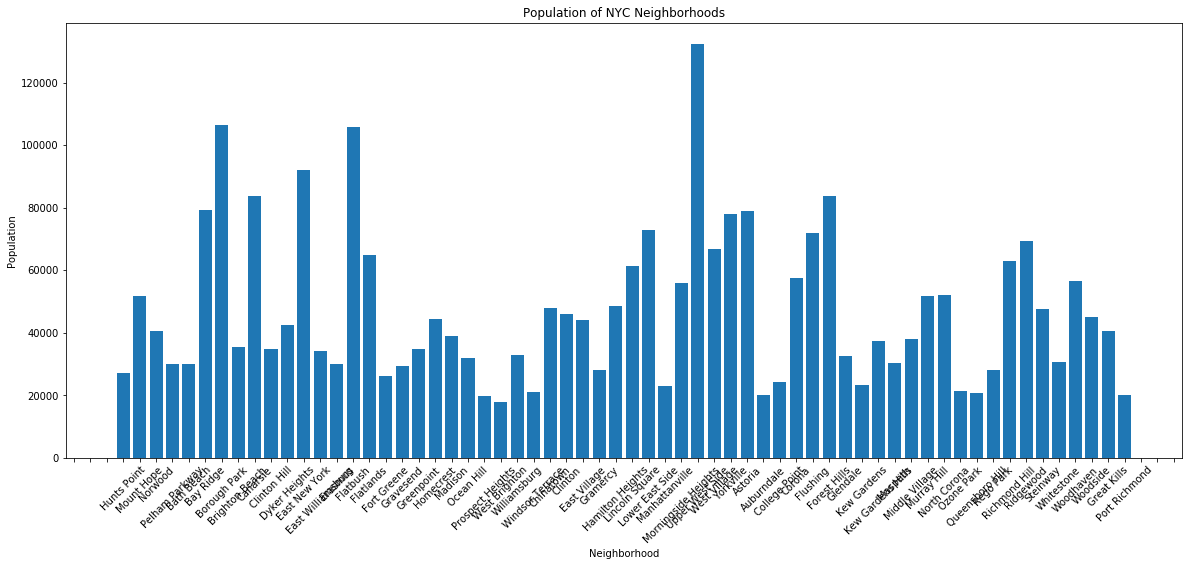

In [22]:
tick_spacing = 1
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(new_york_final['Neighborhood'],new_york_final['Population'],align='center')
plt.xticks(rotation = 45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlabel("Neighborhood")
plt.ylabel("Population")
plt.title("Population of NYC Neighborhoods")
plt.show()

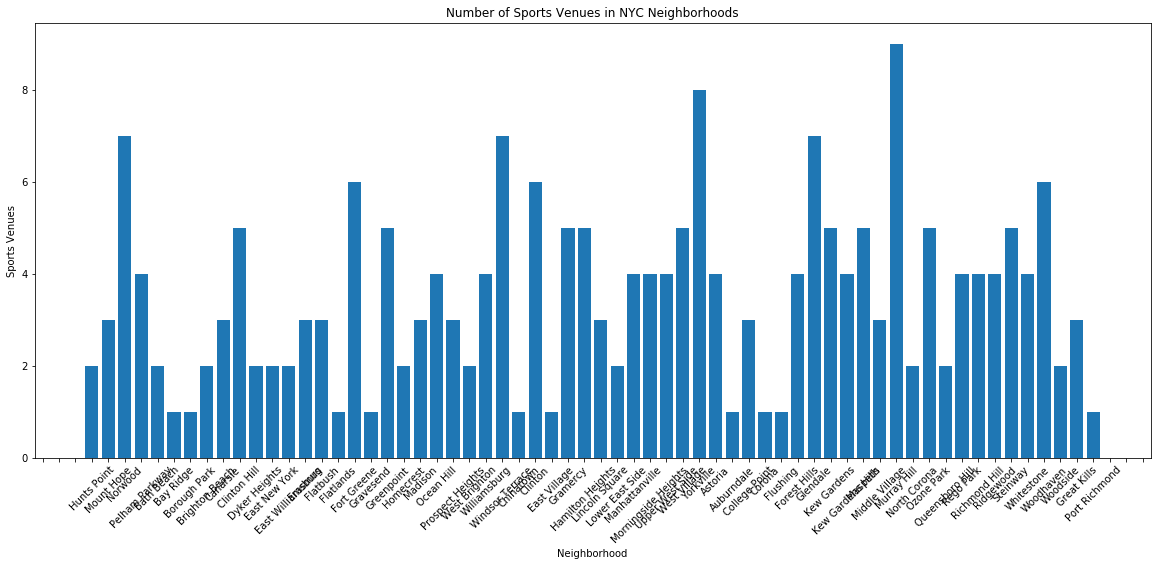

In [23]:
tick_spacing = 1
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(new_york_final['Neighborhood'],new_york_final['Total sports venues'],align='center')
plt.xticks(rotation = 45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlabel("Neighborhood")
plt.ylabel("Sports Venues")
plt.title("Number of Sports Venues in NYC Neighborhoods")
plt.show()

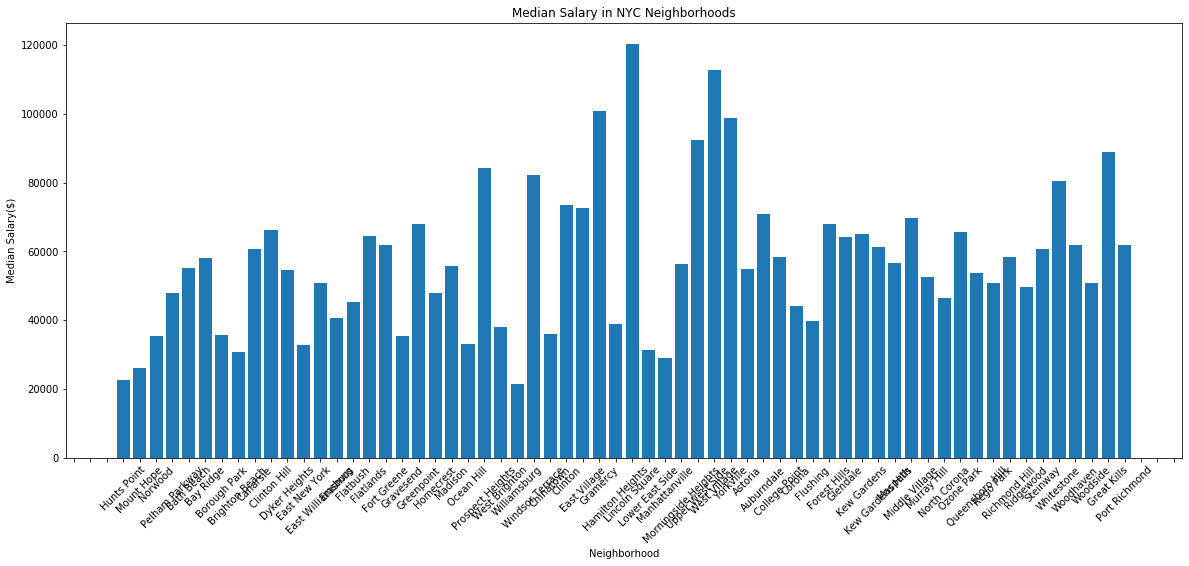

In [24]:
tick_spacing = 1
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(new_york_final['Neighborhood'],new_york_final['Median Salary($)'],align='center')
plt.xticks(rotation = 45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlabel("Neighborhood")
plt.ylabel("Median Salary($)")
plt.title("Median Salary in NYC Neighborhoods")
plt.show()

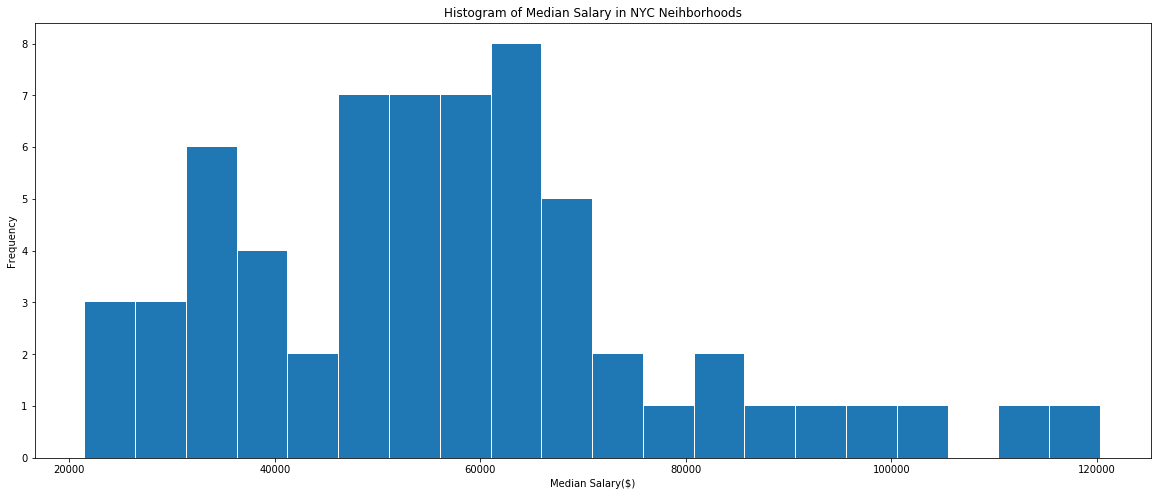

In [25]:
fig, ax = plt.subplots(figsize=(20, 8))
new_york_final['Median Salary($)'].plot(kind = 'hist', bins = 20, rwidth = 0.98)
plt.xlabel("Median Salary($)")
plt.title("Histogram of Median Salary in NYC Neihborhoods")
plt.show()

# K- means clustering

Defining the design matrix

In [27]:
X = new_york_final.iloc[:,3:6]
X = StandardScaler().fit_transform(X)

Elbow method to select the optimal number of clusters

Text(0.5, 1.0, 'Elbow plot for KMeans')

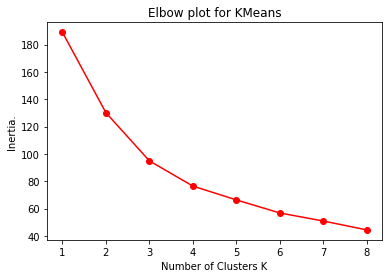

In [46]:
no_of_clusters = [1,2,3,4,5,6,7,8]
Sums_of_squares = []
for k in no_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    Sums_of_squares.append(kmeans.inertia_)
plt.figure()
plt.figsize=(20,10)
plt.plot(no_of_clusters, Sums_of_squares,"o-",color = "red")
plt.xlabel("Number of Clusters K")
plt.ylabel("Inertia.")
plt.title("Elbow plot for KMeans")

In [52]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

In [53]:
Cluster_labels = pd.DataFrame(kmeans.labels_)
Cluster_labels.columns = ['Cluster label']
new_york_final = pd.concat([new_york_final,Cluster_labels],axis = 1)
new_york_final.head(n=10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Population,Total sports venues,Median Salary($),Cluster label
0,Hunts Point,40.809730,-73.883315,27204,2,22572,2
1,Mount Hope,40.848842,-73.908299,51807,3,26195,2
2,Norwood,40.877224,-73.879391,40494,7,35319,0
3,Pelham Parkway,40.857413,-73.854756,30073,4,47806,2
4,Bath Beach,40.599519,-73.998752,29931,2,55193,2
5,Bay Ridge,40.625801,-74.030621,79371,1,57980,1
6,Borough Park,40.633131,-73.990498,106357,1,35754,1
7,Brighton Beach,40.576825,-73.965094,35547,2,30872,2
8,Canarsie,40.635564,-73.902093,83693,3,60766,1
9,Clinton Hill,40.693229,-73.967843,34791,5,66282,0


In [54]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_york_final['Neighborhood Latitude'], new_york_final['Neighborhood Longitude'], new_york_final['Neighborhood'], new_york_final['Cluster label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [55]:
cluster0 = new_york_final[new_york_final['Cluster label'] == 0]
c0_standardised_scores = X[cluster0.index]
features_sums0 = c0_standardised_scores.sum(axis = 1)
mean_sum0 = np.mean(features_sums0)
mean_sum0

1.5090820017823456

In [56]:
cluster1 = new_york_final[new_york_final['Cluster label'] == 1]
c1_standardised_scores = X[cluster1.index]
features_sums1 = c1_standardised_scores.sum(axis = 1)
mean_sum1 = np.mean(features_sums1)
mean_sum1

0.90964950070241

In [57]:
cluster2 = new_york_final[new_york_final['Cluster label'] == 2]
c2_standardised_scores = X[cluster2.index]
c2_standardised_scores
features_sums2 = c2_standardised_scores.sum(axis = 1)
mean_sum2 = np.mean(features_sums2)
mean_sum2

-1.5005574326400204

In [59]:
cluster0

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Population,Total sports venues,Median Salary($),Cluster label
2,Norwood,40.877224,-73.879391,40494,7,35319,0
9,Clinton Hill,40.693229,-73.967843,34791,5,66282,0
16,Fort Greene,40.688527,-73.972906,26079,6,61990,0
18,Greenpoint,40.730201,-73.954241,34719,5,67928,0
22,Prospect Heights,40.676822,-73.964859,19849,3,84323,0
25,Windsor Terrace,40.656946,-73.980073,20988,7,82297,0
27,Clinton,40.759101,-73.996119,45884,6,73591,0
29,Gramercy,40.737210,-73.981376,27988,5,100900,0
31,Lincoln Square,40.773529,-73.985338,61489,3,120337,0
36,West Village,40.734434,-74.006180,66880,5,112689,0


In [60]:
map_cluster0 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(cluster0['Neighborhood Latitude'], cluster0['Neighborhood Longitude'], cluster0['Cluster label'], cluster0['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster3)  
    
map_cluster3